![title](./img/log-6.png "ShowMyImage")

![title](./img/log-4.png "ShowMyImage")

![title](./img/log-5.png "ShowMyImage")

In [17]:

import matplotlib.pyplot as plt

class LogisticRegression(object):
    """LogisticRegression

    Parameters
    ------------
    learningRate : float, optional
        Constant by which updates are multiplied (falls between 0 and 1). Defaults to 0.01.

    numIterations : int, optional
        Number of passes (or epochs) over the training data. Defaults to 10.

    penalty : None or 'L2'
        Option to perform L2 regularization. Defaults to None.

    Attributes
    ------------
    weights : 1d-array, shape = [1, 1 + n_features]
        Weights after training phase

    iterationsPerformed : int
        Number of iterations of gradient descent performed prior to hitting tolerance level

    costs : list, length = numIterations
        Value of the log-likelihood cost function for each iteration of gradient descent

    References
    ------------
    https://en.wikipedia.org/wiki/Logistic_regression
    https://en.wikipedia.org/wiki/Regularization_(mathematics)

    """

    def __init__(self, learningRate, numIterations = 10, penalty = None, C = 0.01):

        self.learningRate = learningRate
        self.numIterations = numIterations
        self.penalty = penalty
        self.C = C

    def train(self, X_train, y_train, tol = 10 ** -4):
        """Fit weights to the training data

        Parameters
        -----------
        X_train : {array-like}, shape = [n_samples, n_features]
            Training data to be fitted, where n_samples is the number of
            samples and n_features is the number of features.

        y_train : array-like, shape = [n_samples,], values = 1|0
            Labels (target values).

        tol : float, optional
            Value indicating the weight change between epochs in which
            gradient descent should terminated. Defaults to 10 ** -4

        Returns:
        -----------
        self : object

        """
        tolerance = tol * np.ones([1, np.shape(X_train)[1] + 1])
        self.weights = np.zeros(np.shape(X_train)[1] + 1)
        X_train = np.c_[np.ones([np.shape(X_train)[0], 1]), X_train]
        self.costs = []

        for i in range(self.numIterations):

            z = np.dot(X_train, self.weights)
            errors = y_train - logistic_func(z)
            if self.penalty is not None:
                delta_w = self.learningRate * (self.C * np.dot(errors, X_train) + np.sum(self.weights))
            else:
                delta_w = self.learningRate * np.dot(errors, X_train)

            self.iterationsPerformed = i

            if np.all(abs(delta_w) >= tolerance):
                #weight update
                self.weights += delta_w
                #Costs
                if self.penalty is not None:
                    self.costs.append(reg_logLiklihood(X_train, self.weights, y_train, self.C))
                else:
                    self.costs.append(logLiklihood(z, y_train))
            else:
                break

        return self

    def predict(self, X_test, pi = 0.5):
        """predict class label

        Parameters
        ------------
        X_test : {array-like}, shape = [n_samples, n_features]
            Testing data, where n_samples is the number of samples
            and n_features is the number of features. n_features must
            be equal to the number of features in X_train.

        pi : float, cut-off probability, optional
            Probability threshold for predicting positive class. Defaults to 0.5.

        Returns
        ------------
        predictions : list, shape = [n_samples,], values = 1|0
            Class label predictions based on the weights fitted following
            training phase.

        probs : list, shape = [n_samples,]
            Probability that the predicted class label is a member of the
            positive class (falls between 0 and 1).

        """
        z = self.weights[0] + np.dot(X_test, self.weights[1:])
        probs = np.array([logistic_func(i) for i in z])
        predictions = np.where(probs >= pi, 1, 0)

        return predictions, probs

    def performanceEval(self, predictions, y_test):
        """Computer binary classification performance metrics

        Parameters
        -----------
        predictions : list, shape = [n_samples,], values = 1|0
            Class label predictions based on the weights fitted following
            training phase.

        y_test : list, shape = [n_samples,], values = 1|0
            True class labels

        Returns
        -----------
        performance : dict
            Accuracy, sensitivity (recall), specificity, postitive predictive
            value (PPV, precision), negative predictive value (NPV), false
            negative rate (FNR, "miss rate"), false positive rate (FPR, "fall out")

        """
        #Initialize
        TP, TN, FP, FN, P, N = 0, 0, 0, 0, 0, 0

        for idx, test_sample in enumerate(y_test):

            if predictions[idx] == 1 and test_sample == 1:
                TP += 1
                P += 1
            elif predictions[idx] == 0 and test_sample == 0:
                TN += 1
                N += 1
            elif predictions[idx] == 0 and test_sample == 1:
                FN += 1
                P += 1
            elif predictions[idx] == 1 and test_sample == 0:
                FP += 1
                N += 1

        accuracy = (TP + TN) / (P + N)
        sensitivity = TP / P
        specificity = TN / N
        PPV = TP / (TP + FP)
        NPV = TN / (TN + FN)
        FNR = 1 - sensitivity
        FPR = 1 - specificity

        performance = {'Accuracy': accuracy, 'Sensitivity': sensitivity,
                       'Specificity': specificity, 'Precision': PPV,
                       'NPV': NPV, 'FNR': FNR, 'FPR': FPR}

        return performance

    def predictionPlot(self, X_test, y_test):
        """Plot of test samples mapped onto the logistic function (sigmoidal
        curve) according to the fitted weights.

        Parameters
        -----------
        X_test : {array-like}, shape = [n_samples, n_features]
            Testing data, where n_samples is the number of samples
            and n_features is the number of features. n_features must
            be equal to the number of features in X_train.

        y_test : list, shape = [n_samples,], values = 1|0
            True class labels

        Returns
        -----------
        matploblib figure

        """
        zs = self.weights[0] + np.dot(X_test, self.weights[1:])
        probs = np.array([logistic_func(i) for i in zs])

        plt.figure()
        plt.plot(np.arange(-10, 10, 0.1), logistic_func(np.arange(-10, 10, 0.1)))
        colors = ['r','b']
        probs = np.array(probs)
        for idx,cl in enumerate(np.unique(y_test)):
            plt.scatter(x = zs[np.where(y_test == cl)[0]], y = probs[np.where(y_test == cl)[0]],
                        alpha = 0.8, c = colors[idx],
                        marker = 'o', label = cl, s = 30)

        plt.xlabel('z')
        plt.ylim([-0.1, 1.1])
        plt.axhline(0.0, ls = 'dotted', color = 'k')
        plt.axhline(1.0, ls = 'dotted', color = 'k')
        plt.axvline(0.0, ls = 'dotted', color = 'k')
        plt.ylabel('phi(z)')
        plt.legend(loc = 'upper left')
        plt.title('Logistic Regression Prediction Curve')
        plt.show()

    def plotCost(self):
        """Plot value of log-liklihood cost function for each epoch

        Returns
        --------
        matplotlib figure

        """
        plt.figure()
        plt.plot(np.arange(1, self.iterationsPerformed + 1), self.costs, marker = '.')
        plt.xlabel('Iterations')
        plt.ylabel('Log-Liklihood J(w)')

    def plotDecisionRegions(self, X_test, y_test, pi = 0.5, res = 0.01):
        """Visualize decision boundaries of trained logistic regression
        classifier. Note, this method can only be used when training classifier
        with 2 features.

        Parameters
        -----------
        X_test : {array-like}, shape = [n_samples, n_features]
            Testing data, where n_samples is the number of samples
            and n_features is the number of features. n_features must
            be equal to the number of features in X_train.

        y_test : list, shape = [n_samples,], values = 1|0
            True class labels

        pi : float, cut-off probability, optional
            Probability threshold for predicting positive class. Defaults to 0.5.

        res : float
            Resolution of contour grid

        Returns
        -----------
        matplotlib figure

        """
        x = np.arange(min(X_test[:,0]) - 1, max(X_test[:,0]) + 1, 0.01)
        y = np.arange(min(X_test[:,1]) - 1, max(X_test[:,1]) + 1, 0.01)
        xx, yy = np.meshgrid(x, y, indexing = 'xy')

        data_points = np.transpose([xx.ravel(), yy.ravel()])
        preds, probs = self.predict(data_points, pi)

        colors = ['r','b']
        probs = np.array(probs)

        for idx,cl in enumerate(np.unique(y_test)):
            plt.scatter(x = X_test[:,0][np.where(y_test == cl)[0]], y = X_test[:,1][np.where(y_test == cl)[0]],
                        alpha = 0.8, c = colors[idx],
                        marker = 'o', label = cl, s = 30)

        preds = preds.reshape(xx.shape)
        plt.contourf(xx, yy, preds, alpha = 0.3)
        plt.legend(loc = 'best')
        plt.xlabel('$x_1$', size = 'x-large')
        plt.ylabel('$x_2$', size = 'x-large')

def logistic_func(z):
    """Logistic (sigmoid) function, inverse of logit function

    Parameters:
    ------------
    z : float
        linear combinations of weights and sample features
        z = w_0 + w_1*x_1 + ... + w_n*x_n

    Returns:
    ---------
    Value of logistic function at z

    """
    return 1 / (1 + np.exp(-z))

def logLiklihood(z, y):
    """Log-liklihood function (cost function to be minimized in logistic
    regression classification)

    Parameters
    -----------
    z : float
        linear combinations of weights and sample features
        z = w_0 + w_1*x_1 + ... + w_n*x_n

    y : list, values = 1|0
        target values

    Returns
    -----------
    Value of log-liklihood function with parameter z and target value y
    """
    return -1 * np.sum((y * np.log(logistic_func(z))) + ((1 - y) * np.log(1 - logistic_func(z))))

def reg_logLiklihood(x, weights, y, C):
    """Regularizd log-liklihood function (cost function to minimized in logistic
    regression classification with L2 regularization)

    Parameters
    -----------
    x : {array-like}, shape = [n_samples, n_features + 1]
        feature vectors. Note, first column of x must be
        a vector of ones.

    weights : 1d-array, shape = [1, 1 + n_features]
        Coefficients that weight each samples feature vector

    y : list, shape = [n_samples,], values = 1|0
        target values

    C : float
        Regularization parameter. C is equal to 1/lambda

    Returns
    -----------
    Value of regularized log-liklihood function with the given feature values,
    weights, target values, and regularization parameter

    """
    z = np.dot(x, weights)
    reg_term = (1 / (2 * C)) * np.dot(weights.T, weights)

    return -1 * np.sum((y * np.log(logistic_func(z))) + ((1 - y) * np.log(1 - logistic_func(z)))) + reg_term


In [15]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header = None)
df.to_csv('./data/logistic_data.data',header=None)

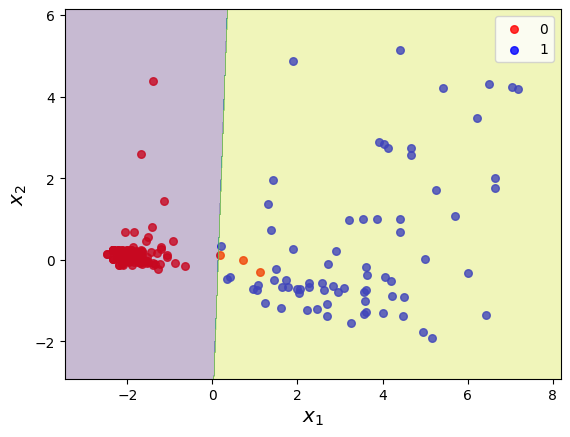

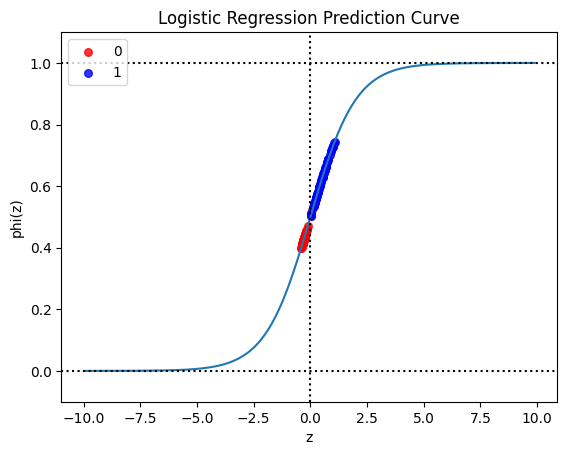

Accuracy : 0.99
Sensitivity : 1.00
Specificity : 0.98
Precision : 0.96
NPV : 1.00
FNR : 0.00
FPR : 0.02


'\nNote, it is often best practice to use k-fold cross-validation to obtain a reliable estimate of this models generalization error. Increases in performance can also be obtained by tuning the regularization parameter, in which case holdout cross-validation should be used.\n'

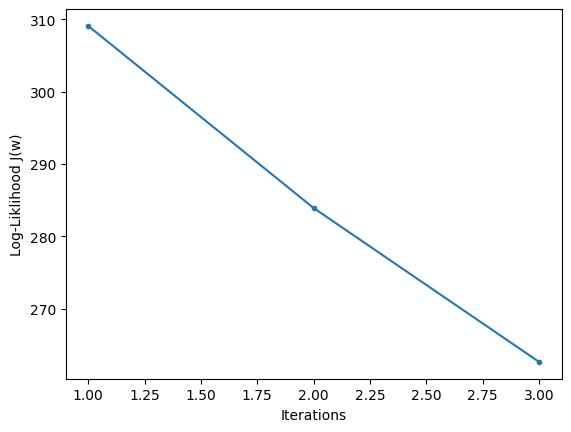

In [20]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 20 12:35:34 2017

@author: gyan

Classification of data in the Breast Cancer Wisconsin dataset using the
LogisticRegression class with L2 regularization. More detailed information
on this dataset can be found at:

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

"""
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
##Import Breast Cancer Wisconsin dataset
# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header = None)
df = pd.read_csv('./data/logistic_data.data',header=None)

X = df.loc[:, 1:10] #features vectors
y = df.loc[:, 10]   #class labels: 2 = benign, 4 = malignant

le = LabelEncoder() #positive class = 1 (benign), negative class = 0 (malignant)
y = le.fit_transform(y)

#Replace missing feature values with mean feature value
X = X.replace('?', np.nan)
# imr = impute(missing_values = 'NaN', strategy = 'mean', axis = 0)
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(X)
X_imputed = imr.transform(X.values)

#Split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size = 0.3, random_state = 1)

#Z-score normalization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Principle component analysis (dimensionality reduction)
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Training logistic regression classifier with L2 penalty
LR = LogisticRegression(learningRate = 0.01, numIterations = 20, penalty = 'L2', C = 0.01)
LR.train(X_train_pca, y_train, tol = 10 ** -3)

#Testing fitted model on test data with cutoff probability 50%
predictions, probs = LR.predict(X_test_pca, 0.5)
performance = LR.performanceEval(predictions, y_test)
LR.plotDecisionRegions(X_test_pca, y_test)
LR.predictionPlot(X_test_pca, y_test)
LR.plotCost()
#Print out performance values
for key, value in performance.items():
    print('%s : %.2f' % (key, value))

'''
Note, it is often best practice to use k-fold cross-validation to obtain a reliable estimate of this models generalization error. Increases in performance can also be obtained by tuning the regularization parameter, in which case holdout cross-validation should be used.
'''